In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
df = pd.read_csv("emails.csv")

In [4]:
df.shape

(5728, 2)

In [5]:
df.groupby("spam").describe()

text                                                               
     count unique                                                top freq
spam                                                                     
0     4360   4327  Subject: * special notification * aurora versi...    2
1     1368   1368  Subject: naturally irresistible your corporate...    1

In [6]:
df = df.sample(frac=1)

In [7]:
X, y = df["text"], df["spam"]
X, y = X.to_frame(), y.to_frame()

In [8]:
X

,text
2010,"Subject: interviews hi vince , thanks for ta..."
4511,Subject: re : re : conference volume hi vince...
1912,Subject: mscf speaker series mscf speaker ser...
4349,Subject: iafe update dear iafe member : i wo...
1424,"Subject: re : gordon , it was a pleasure tal..."
...,...
222,"Subject: sex is a play , and you must win ! y..."
4584,Subject: july conference on real options plea...
5564,Subject: re : mgmt 656 ( rice university ) th...
5263,"Subject: re : congrats vince , you beat me t..."


In [9]:
y

,spam
2010,0
4511,0
1912,0
4349,0
1424,0
...,...
222,1
4584,0
5564,0
5263,0


In [10]:
import nltk
import re

def text_preprocess(sentence):
    # Tokenization
    tokens = nltk.word_tokenize(sentence)

    # Symbol Removal
    n_corpus = []
    for i in range(len(tokens)):
        review = re.sub(r"[^a-zA-Z]", " ", tokens[i])
        review = review.lower()
        n_corpus.append(review)

    # Stopword Removal
    stopwords = nltk.corpus.stopwords.words("english")
    rem_stopwords = [words for words in n_corpus if words not in stopwords and 
                     len(words.split()) != 0 and 
                     len(words) > 2]

    # Lemmatization
    lemmatizer = nltk.stem.WordNetLemmatizer()
    transformed_words = [lemmatizer.lemmatize(words) for words in rem_stopwords]

    return " ".join(transformed_words)

In [11]:
with tf.device("CPU"):
    X["new_text"] = X["text"].apply(text_preprocess)

In [12]:
X.head()

,text,new_text
2010,"Subject: interviews hi vince , thanks for ta...",subject interview vince thanks taking time mee...
4511,Subject: re : re : conference volume hi vince...,subject conference volume vince resending requ...
1912,Subject: mscf speaker series mscf speaker ser...,subject mscf speaker series mscf speaker serie...
4349,Subject: iafe update dear iafe member : i wo...,subject iafe update dear iafe member would lik...
1424,"Subject: re : gordon , it was a pleasure tal...",subject gordon pleasure talking shall ask assi...


In [13]:
y["spam"]

2010    0
4511    0
1912    0
4349    0
1424    0
       ..
222     1
4584    0
5564    0
5263    0
4828    0
Name: spam, Length: 5728, dtype: int64

## Visualizing spam words

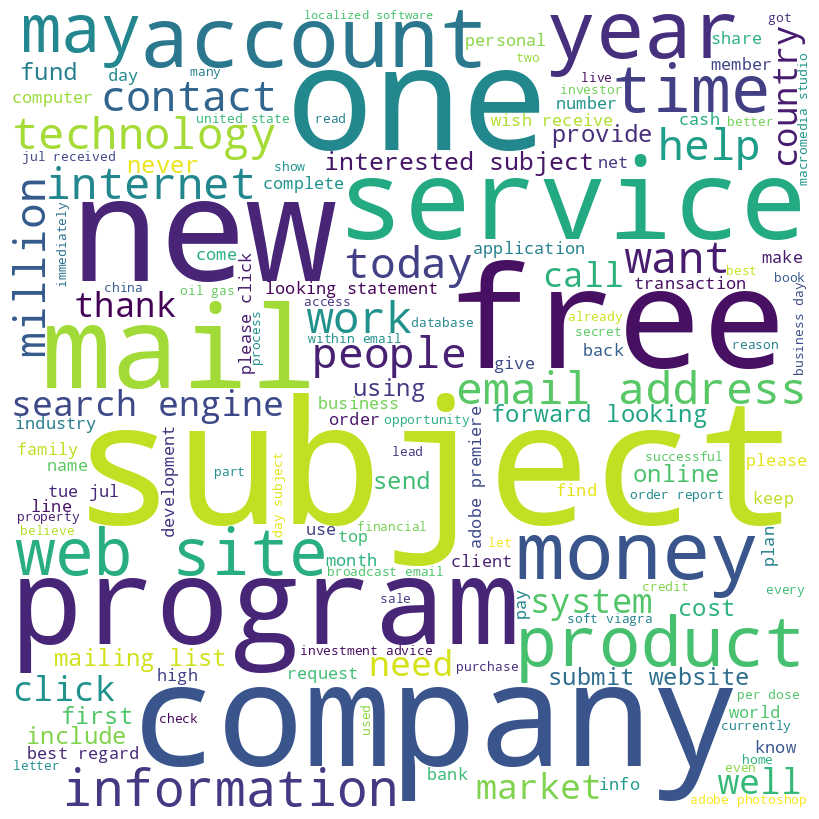

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

comment_words = " ".join([X._get_value(i, "new_text") for i in range(len(y)) 
                          if y._get_value(i, "spam") == 1])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
                   
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Visualizing ham words

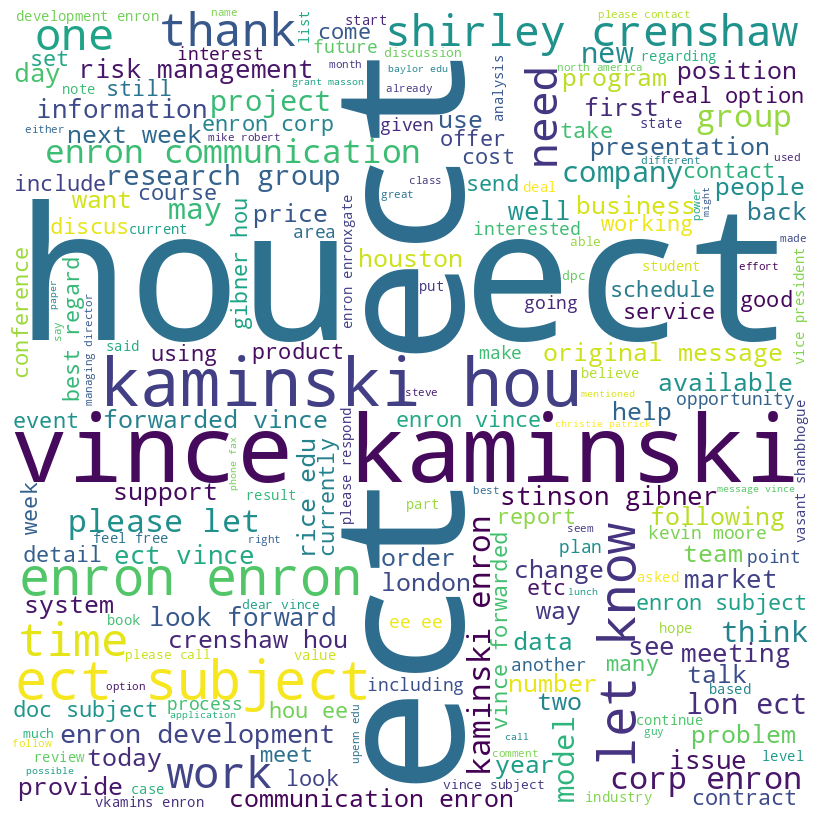

In [15]:
comment_words = " ".join([X._get_value(i, "new_text") for i in range(len(y)) 
                          if y._get_value(i, "spam") == 0])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
                   
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## One hot Encoding

In [16]:
from tensorflow.keras.preprocessing.text import one_hot

In [17]:
vocab_size = 5000

In [18]:
encoded_words = [one_hot(words, vocab_size) for words in X["new_text"]]

## Word Embedding

In [19]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

In [20]:
max_length = len(max(X["new_text"]))

In [21]:
embedded_words = pad_sequences(encoded_words, padding="pre", maxlen=max_length)
print(embedded_words)

[[   0    0    0 ... 1558  234 4823]
 [   0    0    0 ... 3026 3984 1558]
 [   0    0    0 ... 3920  165 3256]
 ...
 [   0    0    0 ... 2835 2100   62]
 [   0    0    0 ... 2096 3443 4026]
 [   0    0    0 ... 2224 3786   71]]


## LSTM Model

In [22]:
feature_dim = 50

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_length, trainable=False))
model.add(LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3, dropout = 0.5))
model.add(LSTM(units = 64, recurrent_dropout = 0.3, dropout = 0.5))
model.add(Dense(units = 32, activation = "relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 581, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 581, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 823,105
Trainable params: 183,105
Non-trainable params: 640,000
_________________________________________________________________


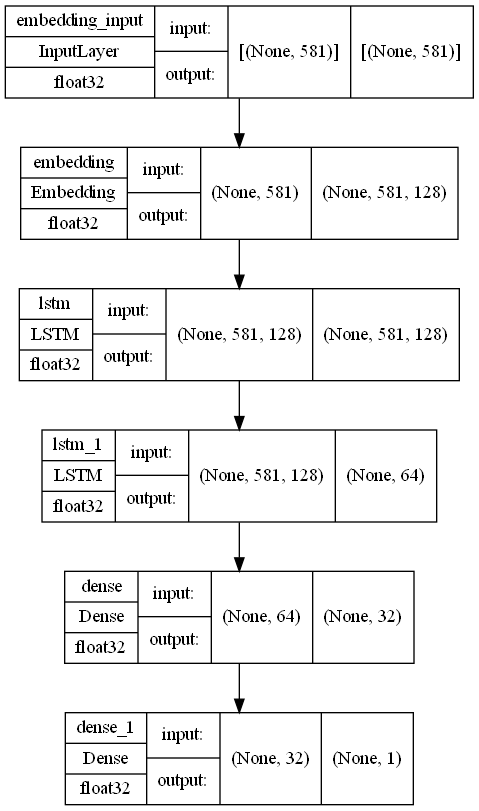

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [26]:
X_final, y_final = np.array(embedded_words), np.array(y)

In [27]:
X_final.shape

(5728, 581)

In [28]:
y_final.shape

(5728, 1)

## Splitting into Training and Testing

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.25, random_state=42)

In [30]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10


 3/68 [>.............................] - ETA: 8:42 - loss: 0.6895 - accuracy: 0.6198

KeyboardInterrupt: 

In [ ]:
model.save("spam_classifier_model.h5")

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([[8.2637780e-05],
       [3.4838406e-05],
       [2.3897903e-05],
       ...,
       [2.9713519e-05],
       [9.9992156e-01],
       [3.3024753e-05]], dtype=float32)

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1059,    4],
       [  23,  346]], dtype=int64)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9811452513966481

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1063
           1       0.99      0.94      0.96       369

    accuracy                           0.98      1432
   macro avg       0.98      0.97      0.97      1432
weighted avg       0.98      0.98      0.98      1432

